In [42]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.nn.functional as F

import os
import helper as hp
from configparser import ConfigParser
from ppo_refinement import PPORefinement

from kinetics.jacobian_solver import check_jacobian
import concurrent.futures
from functools import partial
import threading

# Define PPO

In [43]:
class Actor(nn.Module):
    def __init__(self, state_dim, param_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.param_dim = param_dim
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, param_dim)
        self.fc_log_std = nn.Linear(hidden_dim, param_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        mu = self.fc_mu(x)
        log_std = self.fc_log_std(x)
        # Clamp log_std to avoid extremely small or large std values
        log_std = torch.clamp(log_std, -20, 2)
        return mu, log_std

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_value = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        value = self.fc_value(x)
        return value


In [51]:
class PPORefinement:
    def __init__(self, param_dim, noise_dim, reward_function,
                 min_x_bounds, max_x_bounds,
                 hidden_dim_actor=256, hidden_dim_critic=256,
                 actor_lr=3e-4, critic_lr=1e-3,
                 gamma=0.99, ppo_epochs=4, epsilon=0.2,
                 gae_lambda=0.95, T_horizon=20,
                 device=None):

        self.param_dim = param_dim
        self.noise_dim = noise_dim
        self.state_dim = noise_dim + param_dim
        self.reward_function = reward_function
        self.scale_action = 1.0

        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        self.min_x_bounds = torch.tensor(min_x_bounds, device=self.device, dtype=torch.float32)
        self.max_x_bounds = torch.tensor(max_x_bounds, device=self.device, dtype=torch.float32)
        if self.min_x_bounds.shape == (): # scalar
            self.min_x_bounds = self.min_x_bounds.repeat(param_dim)
        if self.max_x_bounds.shape == (): # scalar
            self.max_x_bounds = self.max_x_bounds.repeat(param_dim)


        self.gamma = gamma
        self.epsilon = epsilon
        self.ppo_epochs = ppo_epochs
        self.gae_lambda = gae_lambda
        self.T_horizon = T_horizon

        self.actor = Actor(self.state_dim, param_dim, hidden_dim_actor).to(self.device)
        self.critic = Critic(self.state_dim, hidden_dim_critic).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.mse_loss = nn.MSELoss()

    def _transform_to_bounded(self, params_raw):
        # Clip params_raw to the range [min_x_bounds, max_x_bounds]
        return torch.clamp(params_raw, min=self.min_x_bounds, max=self.max_x_bounds)

    def _initialize_current_params_for_state(self):
        # Start with parameters uniformly in the range of min_x_bounds and max_x_bounds
        current_params_in_state = torch.rand(self.param_dim, device=self.device) * (self.max_x_bounds - self.min_x_bounds) + self.min_x_bounds
        # Or use: torch.randn(self.param_dim, device=self.device) * 0.1 # Small random noise
        # current_params_in_state = torch.randn(self.param_dim, device=self.device) * 0.1
        return current_params_in_state

    def collect_rollout_data(self):
        states, actions_raw, log_probs_raw, rewards, dones, values = [], [], [], [], [], []

        current_params_in_state = self._initialize_current_params_for_state().clone() # Shape: (param_dim)
        final_ode_params = None

        for t in range(self.T_horizon):
            noise = torch.randn(self.noise_dim, device=self.device) # Shape: (noise_dim)
            state_1d = torch.cat((noise, current_params_in_state.detach()), dim=0) # Shape: (state_dim)
            state_batch = state_1d.unsqueeze(0) # Shape: (1, state_dim) for actor/critic

            with torch.no_grad(): # During data collection, no grad needed for actor/critic forward pass
                mu_raw, log_std_raw = self.actor(state_batch) # mu_raw: (1, param_dim), log_std_raw: (1, param_dim)
                std_raw = torch.exp(log_std_raw)
                dist = Normal(mu_raw, std_raw)
                action_raw = dist.sample() # Shape: (1, param_dim)
                action_log_prob_raw = dist.log_prob(action_raw).sum(dim=-1) # Shape: (1)
                val = self.critic(state_batch) # Shape: (1, 1)

            ode_params = self._transform_to_bounded(action_raw) # Shape: (1, param_dim)

            if t == self.T_horizon - 1:
                # Squeeze action_raw to 1D tensor for reward function
                r = self.reward_function(ode_params.squeeze(0))
                d = True
                final_ode_params = ode_params.squeeze(0).detach()
            else:
                r = 0.0 # No intermediate rewards
                d = False

            states.append(state_1d) # Store 1D state
            actions_raw.append(action_raw.squeeze(0)) # Store 1D action_raw
            log_probs_raw.append(action_log_prob_raw.squeeze(0)) # Store scalar log_prob
            rewards.append(torch.tensor(r, device=self.device, dtype=torch.float32))
            dones.append(torch.tensor(d, device=self.device, dtype=torch.bool))
            values.append(val.squeeze()) # Store scalar value

            current_params_in_state = ode_params.squeeze(0) # Update for next state, Shape: (param_dim)

        # Print mean reward for the episode
        mean_reward = torch.mean(torch.stack(rewards)).item()
        # print(f"Mean reward for the episode: {mean_reward:.4f}")

        # Convert lists to tensors
        rollout_data = (
            torch.stack(states),
            torch.stack(actions_raw),
            torch.stack(log_probs_raw),
            torch.stack(rewards),
            torch.stack(dones),
            torch.stack(values)
        )
        return rollout_data, final_ode_params

    def update_policy(self, rollout_data):
        states, actions_raw, old_log_probs_raw, rewards, dones, old_values = rollout_data
        old_values = old_values.detach() # Ensure no gradients flow back to critic from here

        # Calculate advantages and returns using GAE
        advantages = torch.zeros_like(rewards, device=self.device)
        returns = torch.zeros_like(rewards, device=self.device)
        gae = 0
        # next_val for the last state is 0 because the episode terminates
        next_val = torch.tensor(0.0, device=self.device)

        for t in reversed(range(len(rewards))):
            # if dones[t] is True, (1.0 - dones[t].float()) will be 0
            delta = rewards[t] + self.gamma * next_val * (1.0 - dones[t].float()) - old_values[t]
            gae = delta + self.gamma * self.gae_lambda * (1.0 - dones[t].float()) * gae
            advantages[t] = gae
            returns[t] = gae + old_values[t] # Q_t = A_t + V(s_t)
            next_val = old_values[t]

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Optimize policy and value network for K epochs
        for _ in range(self.ppo_epochs):
            # Actor update
            mu_raw, log_std_raw = self.actor(states)
            std_raw = torch.exp(log_std_raw)
            dist_new = Normal(mu_raw, std_raw)
            new_log_probs_raw = dist_new.log_prob(actions_raw).sum(dim=-1)

            ratios = torch.exp(new_log_probs_raw - old_log_probs_raw.detach())

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.epsilon, 1 + self.epsilon) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            # Optional: Add entropy bonus
            # entropy = dist_new.entropy().sum(-1).mean()
            # actor_loss -= 0.01 * entropy


            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            # Optional: Gradient clipping for actor
            # torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)
            self.actor_optimizer.step()

            # Critic update
            current_values = self.critic(states).squeeze(-1) # Shape: (T_horizon)
            critic_loss = self.mse_loss(current_values, returns.detach())

            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            # Optional: Gradient clipping for critic
            # torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
            self.critic_optimizer.step()

    def train(self, num_training_iterations, output_path=None):
        print(f"Training on {self.device}")
        final_rewards = []
        for iteration in range(num_training_iterations):
            rollout_data_tuple, final_ode_params = self.collect_rollout_data()
            self.update_policy(rollout_data_tuple)

            if final_ode_params is not None:
                final_reward = self.reward_function(final_ode_params)
                final_rewards.append(final_reward)
                if (iteration + 1) % 1 == 0: # Log every iteration
                    print(f"Iteration {iteration+1}/{num_training_iterations}, Final Reward: {final_reward:.4f}")
                    # print(f"   Final ODE Params: {final_ode_params.cpu().numpy()}")
            # save the model every 2 iterations
            if (iteration + 1) % 100 == 0:
                torch.save(self.actor.state_dict(), output_path + f"actor_{iteration+1}.pth")
                torch.save(self.critic.state_dict(), output_path + f"critic_{iteration+1}.pth")
                print(f"Model saved at iteration {iteration+1}")

        # save final rewards
        if output_path is not None:
            np.save(output_path + "final_rewards.npy", final_rewards)
            print(f"Final rewards saved at {output_path}final_rewards.npy")

        print("Training finished.")
        # You can return the trained actor or save it
        return self.actor, final_rewards


# Train PPO agent

In [52]:
#Parse arguments from configfile
configs = ConfigParser()
configs.read('configfile.ini')

n_samples = int(configs['MLP']['n_samples']) # Used by MLP for its internal sampling if any, and for p0 generation.

lnminkm = float(configs['CONSTRAINTS']['min_km'])
lnmaxkm = float(configs['CONSTRAINTS']['max_km'])

repeats = int(configs['EVOSTRAT']['repeats'])
generations = int(configs['EVOSTRAT']['generations']) # Will be used as num_iterations for PPO
ss_idx = int(configs['EVOSTRAT']['ss_idx'])
# n_threads = int(configs['EVOSTRAT']['n_threads']) # PPO collection is currently single-threaded

output_path = configs['PATHS']['output_path']
met_model = configs['PATHS']['met_model']
names_km_config = hp.load_pkl(f'models/{met_model}/parameter_names_km_fdp1.pkl') # Full list of param names

# Parameters needed directly by PPORefinement
param_dim_config = int(configs['MLP']['no_kms'])
latent_dim_config = int(configs['MLP']['latent_dim']) # For z vector in state


# Call solvers from SKimPy (Used only for initial messages now)
chk_jcbn = check_jacobian()

In [53]:
# Integrate data
print('---- Load kinetic and thermodynamic data')
chk_jcbn._load_ktmodels(met_model, 'fdp1')           ## Load kinetic and thermodynamic data
print('---- Load steady state data')
chk_jcbn._load_ssprofile(met_model, 'fdp1', ss_idx)  ## Integrate steady state information

---- Load kinetic and thermodynamic data


2025-05-14 13:58:48,199 - thermomodel_new - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2025-05-14 13:58:49,802 - Unnamed - WARNING - Non integer stoichiometries found ['CYTBO3_4pp', 'LMPD_biomass_c_1_420', 'CYTBDpp'] change to integer for linear dependencies
2025-05-14 13:58:50,092 - Unnamed - WARNING - Non integer stoichiometries found ['CYTBO3_4pp', 'LMPD_biomass_c_1_420', 'CYTBDpp'] change to integer for linear dependencies


---- Load steady state data


In [54]:
lambda_partition = -2.5
reward_flag = 0

def _get_lambda_max(p_tensor_single):
    p_numpy = p_tensor_single.detach().cpu().numpy()
    # Use the stored chk_jcbn instance
    chk_jcbn._prepare_parameters([p_numpy], names_km_config) 
    max_eig_list = chk_jcbn.calc_eigenvalues_recal_vmax()
    max_eig_list.sort()

    return max_eig_list

def compute_reward(p_tensor_single, n_consider=10):
    lambdas_val = _get_lambda_max(p_tensor_single)

    if reward_flag == 0:
        lambda_max_val = lambdas_val[0]
        penalty = np.maximum(0, lambda_max_val)
        if lambda_max_val > 100:
            lambda_max_val = 100
        r = 1.0 / (1.0 + np.exp(lambda_max_val - lambda_partition))
        r -= penalty
    else:
        considered_avg = sum(lambdas_val[:n_consider]) / n_consider
        r = np.exp(-0.1 * considered_avg) / 2
    # TODO: Right now, we are not using the Incidence part of the reward.

    return r


In [55]:
print('--- Begin PPO refinement strategy')

this_savepath = f'{output_path}/ppo/' 
os.makedirs(this_savepath, exist_ok=True)

ppo_agent = PPORefinement(
    param_dim=param_dim_config,
    noise_dim=latent_dim_config,
    reward_function=compute_reward,
    min_x_bounds=lnminkm,
    max_x_bounds=lnmaxkm,
    ppo_epochs=10,
    T_horizon=100,
    actor_lr=1e-5,
    critic_lr=5e-5,
)

trained_actor, rewards = ppo_agent.train(num_training_iterations=100, output_path=this_savepath)

print(f"PPO training finished. Rewards log saved to {this_savepath}")


--- Begin PPO refinement strategy
Training on cpu
Iteration 1/100, Final Reward: -70.3939
Iteration 2/100, Final Reward: -71.5383
Iteration 3/100, Final Reward: -69.5212
Iteration 4/100, Final Reward: -68.1717
Iteration 5/100, Final Reward: -69.8698
Iteration 6/100, Final Reward: -70.4421
Iteration 7/100, Final Reward: -70.6747
Iteration 8/100, Final Reward: -72.6684
Iteration 9/100, Final Reward: -70.4747
Iteration 10/100, Final Reward: -69.8210
Iteration 11/100, Final Reward: -70.0481
Iteration 12/100, Final Reward: -70.7699
Iteration 13/100, Final Reward: -69.8235
Iteration 14/100, Final Reward: -71.8571
Iteration 15/100, Final Reward: -71.9711
Iteration 16/100, Final Reward: -69.0475
Iteration 17/100, Final Reward: -69.2146
Iteration 18/100, Final Reward: -71.2547
Iteration 19/100, Final Reward: -69.6141
Iteration 20/100, Final Reward: -70.2687
Iteration 21/100, Final Reward: -70.0105
Iteration 22/100, Final Reward: -71.0516
Iteration 23/100, Final Reward: -68.5641
Iteration 24/100

Text(0.5, 1.0, 'PPO Training Rewards')

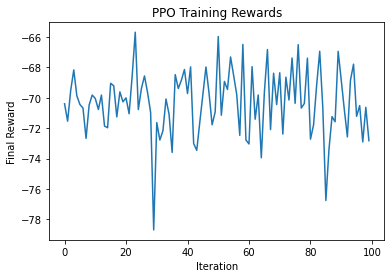

In [56]:
from matplotlib import pyplot as plt
plt.plot(rewards)
plt.xlabel('Iteration')
plt.ylabel('Final Reward')
plt.title('PPO Training Rewards')

In [187]:
def evaluate_policy_incidence(trained_actor, ppo_agent, num_trials=50):
    T_HORIZON = ppo_agent.T_horizon
    NOISE_DIM = ppo_agent.noise_dim
    N_TRIALS = num_trials
    incidence = 0
    for _ in range(N_TRIALS):
        current_params_in_state = ppo_agent._initialize_current_params_for_state().clone()
        generated_sequence = []
        for _ in range(T_HORIZON):
            noise = torch.randn(NOISE_DIM, device=ppo_agent.device)
            state_1d = torch.cat((noise, current_params_in_state.detach()), dim=0)
            state_batch = state_1d.unsqueeze(0)
            with torch.no_grad():
                mu_raw, log_std_raw = trained_actor(state_batch)
                # For generation, you might want to take the mean (mu_raw) or sample
                # action_raw = mu_raw # Deterministic generation
                action_raw = Normal(mu_raw, torch.exp(log_std_raw)).sample() # Stochastic generation
            
            ode_params = ppo_agent._transform_to_bounded(action_raw)
            current_params_in_state = ode_params.squeeze(0)
            generated_sequence.append(current_params_in_state.cpu().numpy())

        final_generated_params = generated_sequence[-1]
        final_reward_eval = compute_reward(torch.tensor(final_generated_params, device=ppo_agent.device))
        lambda_max = _get_lambda_max(torch.tensor(final_generated_params, device=ppo_agent.device))[0]
        if lambda_max < -2.5:
            incidence += 1
        print(f"Final lambda_max: {lambda_max:.4f}")
        print(f"Final reward: {final_reward_eval:.4f}")
    print(f"Incidence over {N_TRIALS} trials: {incidence}/{N_TRIALS} = {incidence/N_TRIALS:.2f}")


In [191]:
evaluate_policy_incidence(trained_actor, ppo_agent, num_trials=50)

Final lambda_max: -0.0430
Final reward: 0.0789
Final lambda_max: 4850.1221
Final reward: 0.0000
Final lambda_max: -0.1436
Final reward: 0.0866
Final lambda_max: 11.9326
Final reward: 0.0000
Final lambda_max: -0.4074
Final reward: 0.1098
Final lambda_max: 2.4517
Final reward: 0.0070
Final lambda_max: -0.2444
Final reward: 0.0949
Final lambda_max: 5571.0459
Final reward: 0.0000
Final lambda_max: 75.5689
Final reward: 0.0000
Final lambda_max: 45.8822
Final reward: 0.0000
Final lambda_max: -1.0108
Final reward: 0.1840
Final lambda_max: 2365.5032
Final reward: 0.0000
Final lambda_max: -0.2672
Final reward: 0.0968
Final lambda_max: -0.5847
Final reward: 0.1284
Final lambda_max: -0.9150
Final reward: 0.1701
Final lambda_max: 84.9147
Final reward: 0.0000
Final lambda_max: 0.3655
Final reward: 0.0539
Final lambda_max: 3752.4040
Final reward: 0.0000
Final lambda_max: -0.4133
Final reward: 0.1104
Final lambda_max: 963.9003
Final reward: 0.0000
Final lambda_max: 1921.8405
Final reward: 0.0000
Fina